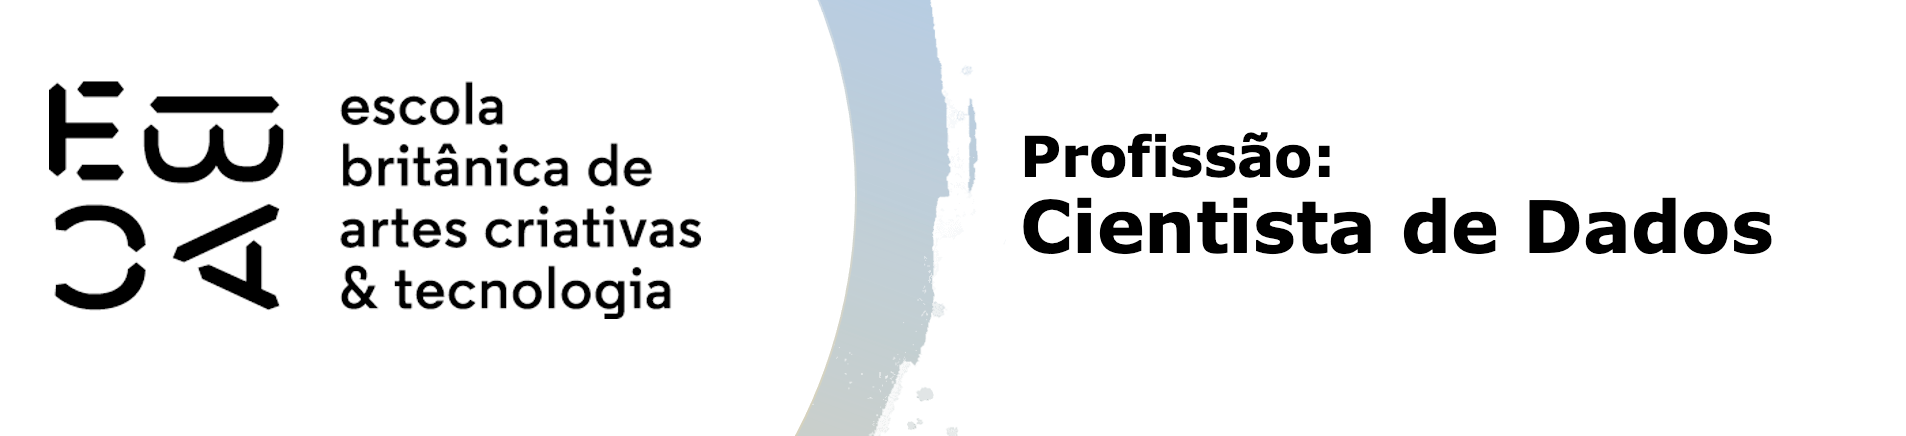

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Carregando a base de dados
df = pd.read_pickle('base_nfp.pkl')

# Visualizando as primeiras linhas da base
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


# Pré-processamento e análise descritiva dos dados

**Análise Descritiva dos Dados:** A ideia aqui é entender a natureza dos dados, distribuições, valores faltantes, etc.

In [2]:
# Informações gerais sobre o dataframe
df.info()

# Análise descritiva básica
print(df.describe())

# Verificando valores nulos
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187646 entries, 0 to 187645
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CNPJ emit.           187646 non-null  object        
 1   Emitente             187646 non-null  object        
 2   No.                  187646 non-null  int64         
 3   Data Emissão         187646 non-null  datetime64[ns]
 4   Valor NF             187646 non-null  float64       
 5   Data Registro        187646 non-null  datetime64[ns]
 6   Créditos             187646 non-null  float64       
 7   Situação do Crédito  187646 non-null  category      
 8   Ano                  187646 non-null  int64         
 9   Semestre             187646 non-null  int64         
 10  Retorno              186666 non-null  float64       
 11  flag_credito         187646 non-null  int64         
 12  categoria            187646 non-null  object        
dtypes: category(1)

**Visualização da Distribuição de Classes:** É sempre bom visualizar a distribuição da variável alvo, para entender se temos um conjunto de dados equilibrado ou desequilibrado.

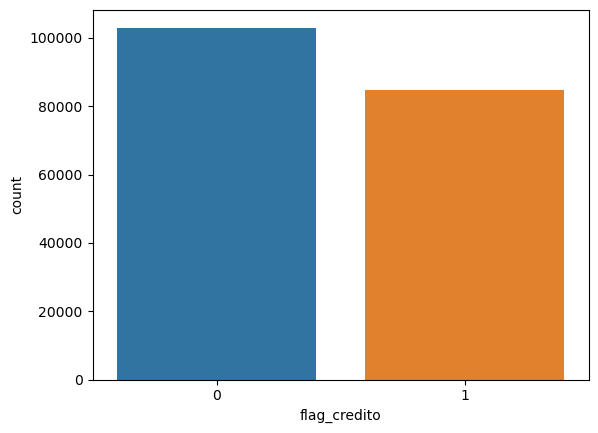

In [3]:
# Observando a distribuição de notas que deram retorno VS as que não deram
sns.countplot(data=df, x='flag_credito')
plt.show()

**Tratamento de Valores Nulos:** A estratégia de preenchimento deve ser decidida com base no conhecimento de domínio e na natureza dos dados.

In [4]:
# Tratando valores nulos
df['Retorno'].fillna(0, inplace=True)  # Aqui você fez uma suposição de que NaN implica em 0 retorno, o que pode ser válido.

**Codificação de Variáveis Categóricas:** Codificar variáveis categóricas para representações numéricas para que os modelos de aprendizado de máquina possam processá-los.

In [5]:
df = pd.get_dummies(df, columns=['categoria'], drop_first=True)

**Exclusão de Colunas Desnecessárias:** Algumas colunas podem não ser úteis para a modelagem, portanto, excluí-las pode ser uma boa estratégia.

In [6]:
df.drop(columns=['CNPJ emit.', 'Emitente', 'Situação do Crédito', 'Créditos', 'Retorno'], inplace=True)

**Engenharia de Recursos:** Criar novos recursos pode ajudar a melhorar a capacidade preditiva do modelo.

In [7]:
# Variáveis temporais
df['dia_da_semana'] = pd.to_datetime(df['Data Emissão']).dt.dayofweek
df['fim_de_semana'] = df['dia_da_semana'].apply(lambda x: 1 if x >= 5 else 0)
df['dia_do_mes'] = pd.to_datetime(df['Data Emissão']).dt.day
df['trimestre'] = pd.to_datetime(df['Data Emissão']).dt.quarter

# Categorização por Quantis para a variável Valor NF
df['valor_nf_5_categorias'] = pd.qcut(df['Valor NF'], q=5, labels=False)
df['valor_nf_10_categorias'] = pd.qcut(df['Valor NF'], q=10, labels=False)
df['valor_nf_20_categorias'] = pd.qcut(df['Valor NF'], q=20, labels=False)
df['valor_nf_50_categorias'] = pd.qcut(df['Valor NF'], q=50, labels=False)

**Cálculo de Informação de Valor (IV):** Esta é uma métrica que ajuda a entender a importância preditiva de uma variável em relação à variável alvo.

In [8]:
import warnings
warnings.filterwarnings('ignore')


def calcular_iv(df, variavel, alvo):
    """
    Calcula a Informação de Valor (IV) de uma variável em relação a uma variável alvo binária.
    """
    # Criando uma tabela de contingência
    ct = pd.crosstab(df[variavel], df[alvo])
    ct.reset_index(drop=True, inplace=True)
    
    # Adicionando pequena constante para evitar divisão por zero
    small_val = 1e-10
    
    # Calculando as proporções
    prop_zero = ct[0] / (ct[0].sum() + small_val)
    prop_one = ct[1] / (ct[1].sum() + small_val)
    
    # Garantindo que as proporções não sejam zero antes de calcular o log
    woe = np.log((prop_zero + small_val) / (prop_one + small_val))
    ct['woe'] = woe.replace([np.inf, -np.inf], 0)  # Substituindo valores infinitos por 0
    
    prop_woe = prop_zero - prop_one
    ct['iv'] = prop_woe * ct['woe']
    
    return ct['iv'].sum()

def calcular_iv_para_todas_variaveis(df, alvo):
    iv_lista = []
    for col in df.columns:
        if col != alvo:
            iv_lista.append((col, calcular_iv(df, col, alvo)))
    return sorted(iv_lista, key=lambda x: x[1], reverse=True)

# Agora, podemos chamar a função e imprimir os resultados
iv_valores = calcular_iv_para_todas_variaveis(df, 'flag_credito')
for var, iv in iv_valores:
    print(f"{var}: IV = {iv:.4f}")

No.: IV = 14.9250
Valor NF: IV = 3.8272
Data Registro: IV = 1.0036
Data Emissão: IV = 0.5159
valor_nf_50_categorias: IV = 0.1523
valor_nf_20_categorias: IV = 0.1245
valor_nf_10_categorias: IV = 0.1066
categoria_Auto posto: IV = 0.0710
valor_nf_5_categorias: IV = 0.0567
categoria_Varejo: IV = 0.0486
dia_do_mes: IV = 0.0437
Ano: IV = 0.0417
categoria_Farmácia: IV = 0.0227
trimestre: IV = 0.0115
dia_da_semana: IV = 0.0069
fim_de_semana: IV = 0.0043
categoria_Restaurantes: IV = 0.0018
categoria_Construção: IV = 0.0017
Semestre: IV = 0.0013
categoria_Mercado: IV = 0.0008
categoria_Vestuário: IV = 0.0007
categoria_não definido: IV = 0.0006


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

<div style="background-color: #e6f7ff; padding: 10px; border-radius: 5px;">
As variáveis "No.", "Valor NF", "Data Registro", e "Data Emissão" são que apresentam os maiores valores de IV, o que indica um alto poder de discriminação em relação ao restante das variáveis.
<br><br>
Observando os IVs das variáveis categorizadas "valor_nf_50_categorias", "valor_nf_20_categorias", "valor_nf_10_categorias" e "valor_nf_5_categorias", notamos uma tendência: quanto maior o número de categorias, maior é o IV.</div>

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

### Configuração e preparação dos dados

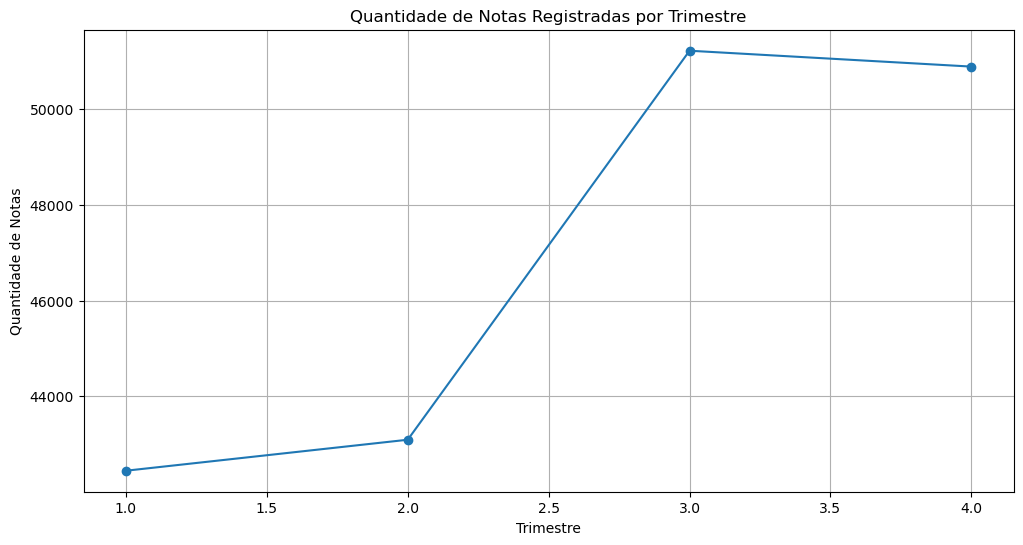

In [9]:
# Agrupando por trimestre e contando o número de registros
notas_por_trimestre = df.groupby('trimestre').size()

# Plotando
plt.figure(figsize=(12, 6))
notas_por_trimestre.plot(kind='line', marker='o')
plt.title('Quantidade de Notas Registradas por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.grid(True)
plt.show()

### Quantidade de notas por categoria e por período

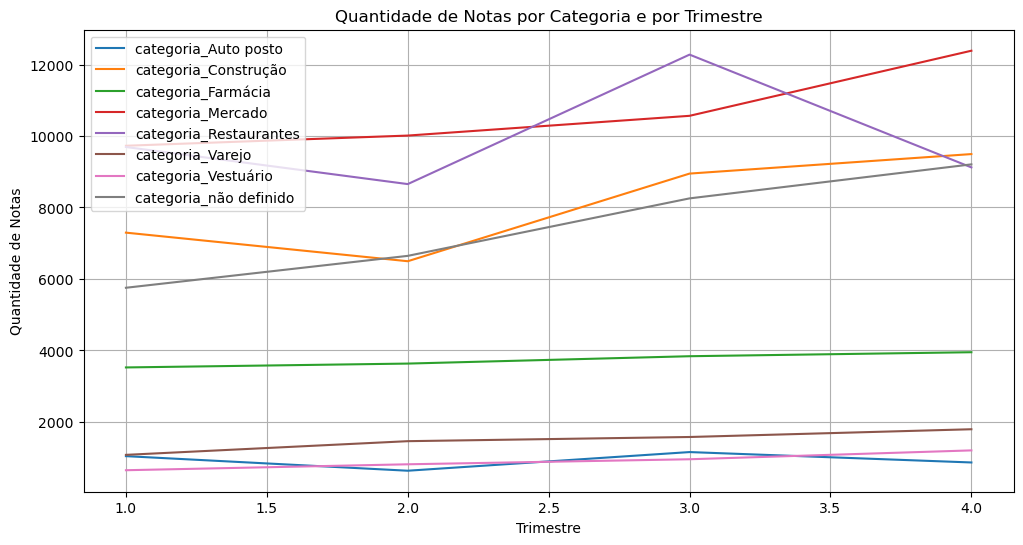

In [10]:
# Lista das colunas de categorias
colunas_categorias = [
    'categoria_Auto posto', 'categoria_Construção', 'categoria_Farmácia',
    'categoria_Mercado', 'categoria_Restaurantes', 'categoria_Varejo',
    'categoria_Vestuário', 'categoria_não definido'
]

# Agrupando por trimestre e somando as categorias
notas_por_categoria_e_trimestre = df.groupby('trimestre')[colunas_categorias].sum()

# Plotando
plt.figure(figsize=(12, 6))
notas_por_categoria_e_trimestre.plot(ax=plt.gca())
plt.title('Quantidade de Notas por Categoria e por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

### Proporção de notas com crédito por categoria por período

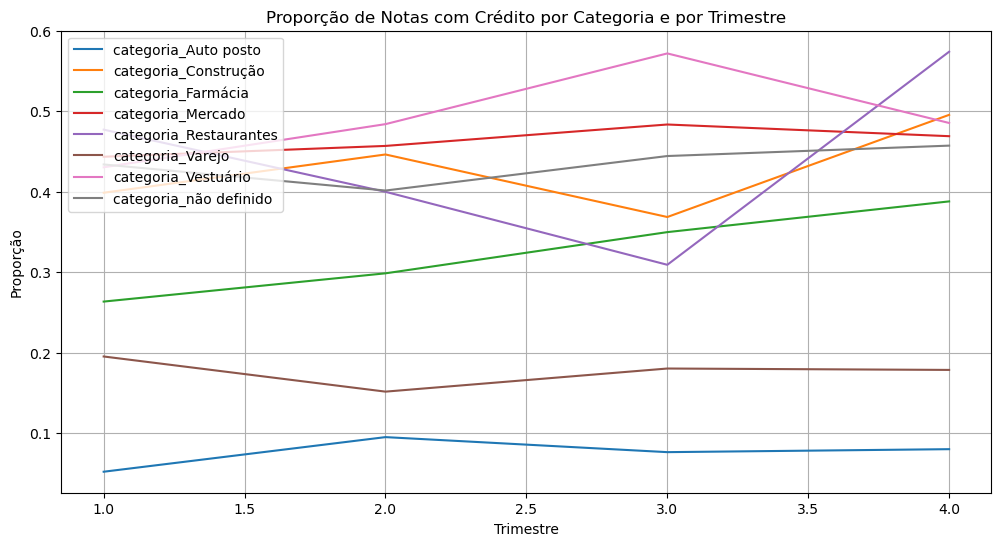

In [12]:
# Lista das colunas de categorias
colunas_categorias = [
    'categoria_Auto posto', 'categoria_Construção', 'categoria_Farmácia',
    'categoria_Mercado', 'categoria_Restaurantes', 'categoria_Varejo',
    'categoria_Vestuário', 'categoria_não definido'
]

# Criando um DataFrame para guardar as proporções de cada categoria
proporcao_credito_por_categoria = pd.DataFrame()

# Calculando proporção de crédito para cada categoria individualmente
for col in colunas_categorias:
    proporcao_credito_por_categoria[col] = df[df[col] == 1].groupby('trimestre')['flag_credito'].mean()


# Plotando
plt.figure(figsize=(12, 6))
proporcao_credito_por_categoria.plot(ax=plt.gca())
plt.title('Proporção de Notas com Crédito por Categoria e por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Proporção')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

### Agrupar os dados da variável "categoria" por trimestre
Como a categoria parece estar representada em colunas dummy, precisamos primeiro reverter para uma única coluna

In [13]:
categorias_cols = ['categoria_Auto posto', 'categoria_Construção', 'categoria_Farmácia', 'categoria_Mercado', 'categoria_Restaurantes', 'categoria_Varejo', 'categoria_Vestuário', 'categoria_não definido']
df['categoria'] = df[categorias_cols].idxmax(axis=1).str.replace("categoria_", "")
grouped = df.groupby(['trimestre', 'categoria'])

### Para cada trimestre e categoria, calcular o % de eventos e % de não eventos

In [14]:
summary = grouped['flag_credito'].agg(['sum', 'count'])
summary['% eventos'] = summary['sum'] / summary['count']
summary['% não eventos'] = 1 - summary['% eventos']

### Usar as proporções para calcular o WOE e IV para cada categoria, em cada trimestre

In [15]:
total_eventos = df['flag_credito'].sum() / df.shape[0]
total_nao_eventos = 1 - total_eventos

summary['WOE'] = np.log((summary['% eventos'] / total_eventos) / (summary['% não eventos'] / total_nao_eventos))
summary['IV'] = (summary['% eventos'] - summary['% não eventos']) * summary['WOE']

### Visualizar o WOE e IV ao longo do tempo (por trimestre) para ver como a relação da variável "categoria" com a variável resposta muda com o tempo

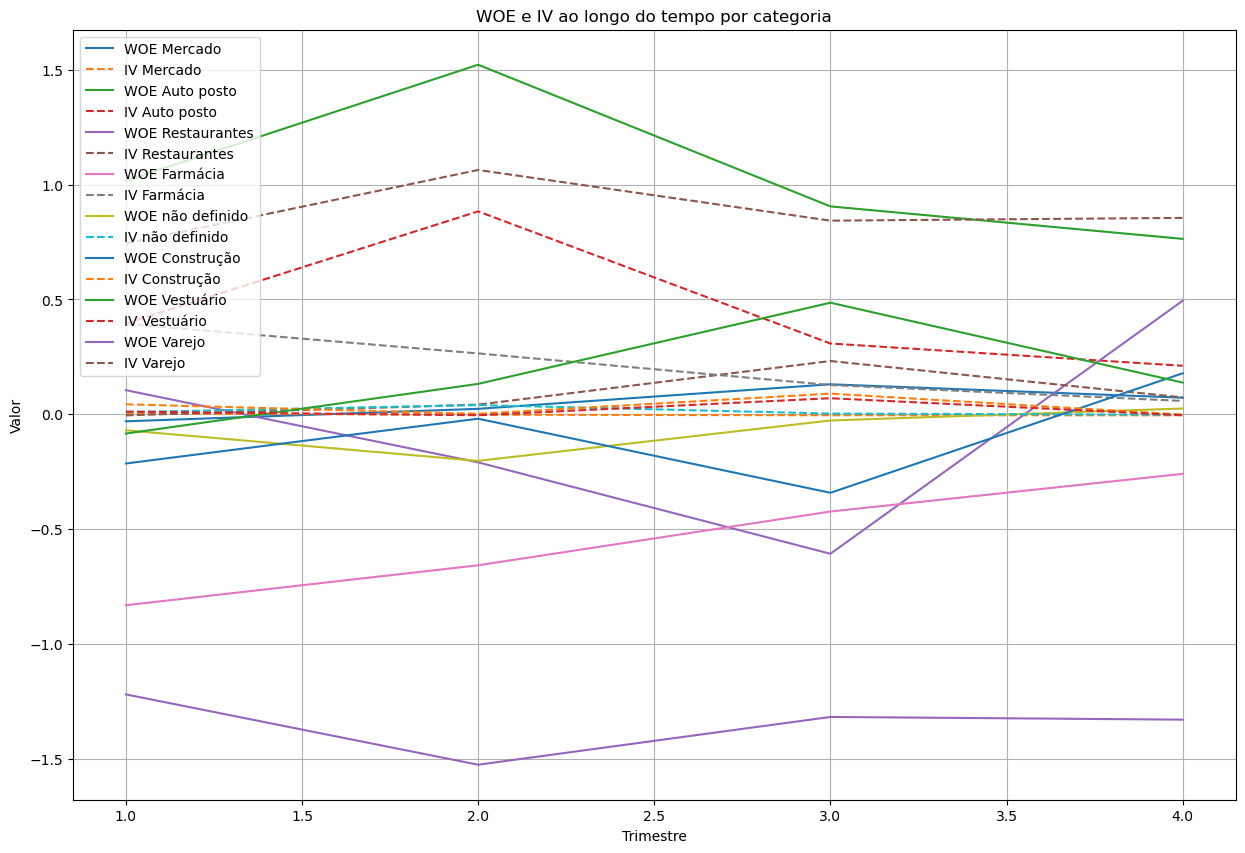

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))  # Ajustando o tamanho da figura: 15 polegadas de largura e 10 polegadas de altura

for categoria in df['categoria'].unique():
    subset = summary.loc[(slice(None), categoria), :]
    plt.plot(subset.index.get_level_values(0), subset['WOE'], label=f'WOE {categoria}')
    plt.plot(subset.index.get_level_values(0), subset['IV'], label=f'IV {categoria}', linestyle='--')

plt.legend(loc='upper left')
plt.title('WOE e IV ao longo do tempo por categoria')
plt.xlabel('Trimestre')
plt.ylabel('Valor')
plt.grid(True)  # Adicionando uma grade para facilitar a visualização
plt.show()

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

As categorias "Mercado" "Varejo", etc destacam-se por apresentar uma proporção significativamente maior de notas com retornos positivos.

Enquanto algumas categorias mantiveram uma proporção estável de retornos positivos ao longo do tempo, outras mostraram variações, especialmente em períodos atípicos.

Desde janeiro de 2020, período marcado por eventos globais como a pandemia e mudanças no perfil do público, observamos que a categoria 'Mercado' tem mostrado um aumento consistente em retornos positivos.

É essencial levar em conta que a quantidade total de notas vem aumentando ao longo do tempo. Além disso, períodos atípicos no histórico podem influenciar as tendências observadas. Portanto, ao interpretar esses resultados, é crucial considerar esses fatores, bem como o contexto mais amplo em que esses dados estão inseridos.